#### Projeto 2 de Modelagem Matemática: pêndulo com oscilações de grande amplitude
###### Aluno: Vitor Mazal Krauss
*Data de Entrega: 02 de Maio de 2019*

###### Objetivos: 

Este trabalho tem especificamente dois objetivos:

1) Considerar alguns modelos de equações diferenciais ordinárias para o movimento de um pêndulo, em particular, do ângulo, e analisar sua capacidade de aproximação/modelagem comparando-o com dados dados experimentais coletados. Em especial, dado cada modelo, buscamos os parâmetros que melhor ajustam o modelo de EDO aos dados.

2) Fazer um estudo de alguns métodos de estimação do período de um pêndulo em função do seu ângulo inicial(ou amplitude). Compararemos as estimativas com os períodos obtidos a partir do experimento, a fim de avaliar a coerência de cada uma.

In [1]:
from os import path, listdir, getcwd
import sys
import io, base64
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants
import scipy.integrate as spi
from scipy.integrate import odeint
from scipy import integrate, optimize
from scipy.signal import argrelextrema, argrelmax
import scipy.signal

videos_dir = path.join('C:\\', 'Users', 'vmk10', 'Desktop', 'C++', 'pendulo_movimento')
movimento_dir = path.join('C:\\', 'Users', 'vmk10', 'Desktop', 'C++', 'movimento')

sys.path.insert(0, path.abspath(path.join(getcwd(),movimento_dir)))
import movimento

g = scipy.constants.g

#### Metodologia

O ângulo que o pêndulo descreve com a vertical satisfaz a seguinte equação diferencial:

$$ \frac{d^2 \theta}{d t^2} + \frac{g}{l}\sin(\theta) = 0 $$

Isto nos mostra imediatamente a necessidade de uma transformação dos nossos dados. Para cada 'frame' amostrado, temos as coordenadas, em pixels, do vértice superior esquerdo da caixa retangular que contém a extremidade do pêndulo(que chamaremos, a partir de agora, de bola), sua largura e altura. Se supormos que o centro(de massa) da bola está no centro desta caixa, podemos calcular as coordenas do centro da bola e, com isso, o ângulo que o pêndulo descreve. Seja $(x_c, y_{max})$ as coordenadas da bola quando $\theta = 0$(chamamos de $y_{max}$ pois, no computador, quanto mais baixo na tela, maior a coordenada $y$). Em cada instante $t$, a bola tem coordenadas $(x_t, y_t)$. Com um pouco de geometria(construindo um triângulo isósceles de lado $l$ e usando a lei dos senos), concluimos que $\theta(t) = \pi - 2\alpha$, onde $\alpha = \arctan(\frac{x_c - x_t}{y_{max}-y_t})$.

In [2]:
def theta(x_t, y_t, x_o, y_max):
    if (x_t < x_o):
        alpha = np.arctan((x_o - x_t)/(y_max - y_t))
        return (np.pi - 2*alpha) % np.pi
    else: 
        alpha = np.arctan((x_t - x_o)/(y_max - y_t))
        return (2*alpha - np.pi) % (-np.pi)
theta = np.vectorize(theta)

In [3]:
def center_coordinates(data):
    xs = [None]*len(data)
    ys = [None]*len(data)
    for i in range(len(data)):
        xs[i] = data[i][1] + data[i][3]/2
        ys[i] = data[i][2] + data[i][4]/2
    return [xs, ys]

Para o pêndulo de $70$ cm.

In [4]:
fps_70cm, num_quadros_70cm, tracado_70cm = movimento.detector_de_movimento(path.join(videos_dir, 'pendulo_70cm_2_reduzido.mov'))

In [5]:
dados_70cm = center_coordinates(tracado_70cm[2:-1])
max_index_70cm = np.argmax(dados_70cm[1])
x_o_70cm = dados_70cm[0][max_index_70cm]
y_max_70cm = dados_70cm[1][max_index_70cm]
angulos_70cm = np.array(theta(np.array(dados_70cm[0]), np.array(dados_70cm[1]), x_o_70cm, y_max_70cm+0.5))

[]

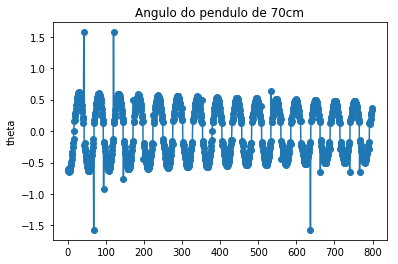

In [6]:
plt.plot(angulos_70cm[200:1000], 'o-')
plt.title("Angulo do pendulo de 70cm")
plt.ylabel("theta")
plt.plot()

Tivemos alguns outliers. Provavelmente consequência de erro numérico de cálculos com ângulo pequeno, o que daria uma divisão por um número muito próximo de zero no cálculo de $\alpha = \arctan(\frac{x_c - x_t}{y_{max}-y_t})$. Devido ao grande tamanho da amostra, eles não vão ser um grande problema e não vamos desconsiderá-los.

Para o pêndulo de $40$ cm.

In [7]:
fps_40cm, num_quadros_40cm, tracado_40cm = movimento.detector_de_movimento(path.join(videos_dir, 'pendulo_40cm_reduzido.mov'))

In [8]:
dados_40cm = center_coordinates(tracado_40cm[2:-1])
max_index_40cm = np.argmax(dados_40cm[1])
x_o_40cm = dados_40cm[0][max_index_40cm]
y_max_40cm = dados_40cm[1][max_index_40cm]
angulos_40cm = np.array(theta(np.array(dados_40cm[0]), np.array(dados_40cm[1]), x_o_40cm, y_max_40cm+0.5))

[]

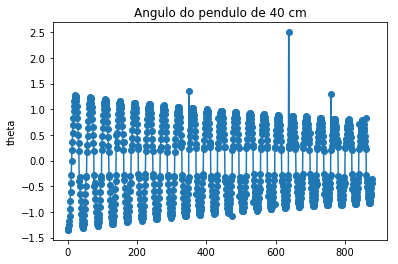

In [9]:
plt.plot(angulos_40cm[120:1000], 'o-')
plt.title("Angulo do pendulo de 40 cm")
plt.ylabel("theta")
plt.plot()

#### Modelagem por EDO's:

A equação diferencial $ \frac{d^2 \theta}{d t^2} + \frac{g}{l}\sin(\theta) = 0 $ vale em um contexto ideal, no qual, por exemplo, não há atrito do pêndulo com ar.

Começamos pela simulação deste modelo, a fim de comparar seu gráfico com o gráfico obtidos dos dados.

In [10]:
print(fps_70cm)
print(num_quadros_70cm)

30.0
3632


Primeiro plottamos os primeiros $4$ segundos. Isto significa os $120$ primeiros quadros.

Obs: os primeiros $\theta$ calculados apresentam valores muito altos. Isto se deve ao fato de no início do vídeo a bola ainda estar sendo posicionada. O verdadeiro ângulo inicial de $\theta$ é dado pelos *offsets* abaixo, que podem ser estimados a partir de uma análise do vídeo(ou dos dados).

In [11]:
offset_70cm = 205
offset_40cm = 120
theta_0_70cm = angulos_70cm[offset_70cm]
theta_0_40cm = angulos_40cm[offset_40cm]

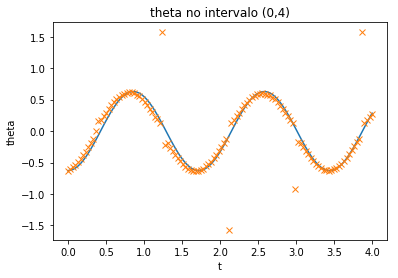

In [12]:
def dU_dx(U, x):
    # Here U is a vector such that y=U[0] and z=U[1]. This function should return [y', z']
    return [U[1], -1*(g/0.7)*np.sin(U[0])]
U0 = [theta_0_70cm, 0]
xs = np.linspace(0, 4, 120)
Us = odeint(dU_dx, U0, xs)

plt.plot(xs, Us[:,0], label='modelo')
plt.plot(xs, angulos_70cm[offset_70cm:offset_70cm+120], 'x', label='dados')
plt.title("theta no intervalo (0,4)")
plt.ylabel("theta")
plt.xlabel("t")
plt.show()

Agora o intervalo completo.

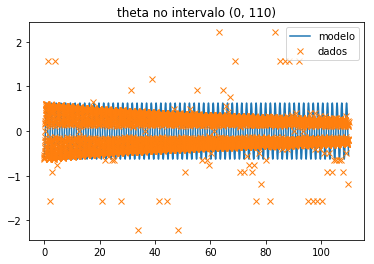

In [13]:
U0 = [theta_0_70cm, 0]
xs = np.linspace(0, 110, 3300)
Us = odeint(dU_dx, U0, xs)

plt.plot(xs, Us[:,0], label='modelo')
plt.plot(xs, angulos_70cm[offset_70cm:offset_70cm+3300], 'x', label='dados')
plt.title("theta no intervalo (0, 110)")
plt.legend()
plt.show()

Observe que para este modelo a amplitude da solução não decresce, enquanto nos dados do experimento a amplitude diminui, uma das razões sendo o atrito do pêndulo com o ar. Assim fica evidente a necessidade de um termo no modelo para levar em conta o atrito(e possivelmente outros termos para outras fontes de erro).

Começamos adotando o seguinte modelo, que leva em consideração o atrito:

$$ \frac{d^2 \theta}{d t^2} + c\frac{d \theta}{d t} + \frac{g}{l}\sin(\theta) = 0 $$

Nosso objetivo é, a partir dos dados experimentais, estimar o valor do parâmetro $c$ que melhor ajusta a solução da EDO aos dados obtidos.

In [14]:
#Criar array com os tempos de cada observação de theta
times_70cm = np.array([(i/30) for i in range(len(angulos_70cm[offset_70cm:-1]))])
times_40cm = np.array([(i/30) for i in range(len(angulos_40cm[offset_40cm:-1]))])

In [15]:
class Parametrize_ODE():
    def __init__(self, xdata, ydata, b_zero, lenght):
        self.X = xdata
        self.y = ydata
        self.y0 = b_zero
        self.l = lenght
    def ode(self, y, t, args):
        theta, omega = y
        dydt = [omega, -args*omega - (g/self.l)*np.sin(theta)]
        return dydt
    def model(self, X, *args):
            sol = integrate.odeint(self.ode, self.y0, X, *args)
            return [sol[i][0] for i in range(len(sol))] 
    def f_resid(self, c):
            return np.sum(self.y - self.model(self.X, (c,)))
    def optim(self):
        return optimize.minimize_scalar(self.f_resid)

Primeiro os dados para o pêndulo de $70$ cm.

In [16]:
po = Parametrize_ODE(times_70cm, np.array(angulos_70cm[offset_70cm:-1]), np.array([theta_0_70cm, 0]), 0.7)
optimal_70cm = po.optim()
print("Sucesso da otimizacao = ", optimal_70cm['success'])
print("Valor otimo de c = ", optimal_70cm['x'])

Sucesso da otimizacao =  True
Valor otimo de c =  0.04957321712646478


E analisamos a coerência do nosso fit em diferentes intervalos de tempo.

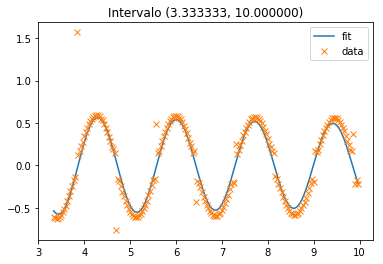

In [17]:
plt.plot(times_70cm[100:300], po.model(po.X, (optimal_70cm['x'],))[100:300], label='fit')
plt.plot(times_70cm[100:300], po.y[100:300], 'x', label='data')
plt.legend()
plt.title("Intervalo (%f, %f)" %(times_70cm[100], times_70cm[300]))
plt.show()

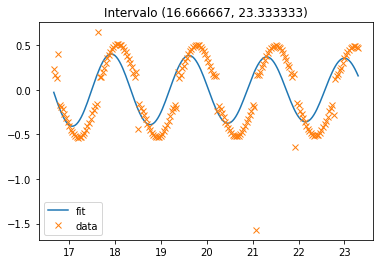

In [18]:
plt.plot(times_70cm[500:700], po.model(po.X, (optimal_70cm['x'],))[500:700], label='fit')
plt.plot(times_70cm[500:700], po.y[500:700], 'x', label='data')
plt.legend()
plt.title("Intervalo (%f, %f)" %(times_70cm[500], times_70cm[700]))
plt.show()

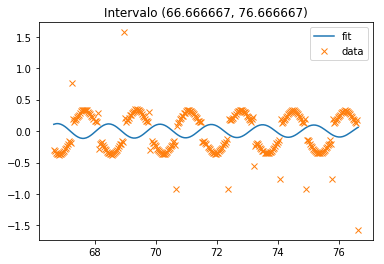

In [19]:
plt.plot(times_70cm[2000:2300], po.model(po.X, (optimal_70cm['x'],))[2000:2300], label='fit')
plt.plot(times_70cm[2000:2300], po.y[2000:2300], 'x', label='data')
plt.legend()
plt.title("Intervalo (%f, %f)" %(times_70cm[2000], times_70cm[2300]))
plt.show()

Agora para o pêndulo de $40$ cm.

In [20]:
p1 = Parametrize_ODE(times_40cm, np.array(angulos_40cm[offset_40cm:-1]), np.array([theta_0_40cm, 0]), 0.4)
optimal_40cm = p1.optim()
print("Sucesso da otimizacao = ", optimal_40cm['success'])
print("Valor otimo de c = ", optimal_40cm['x'])

Sucesso da otimizacao =  True
Valor otimo de c =  0.06982356836780707


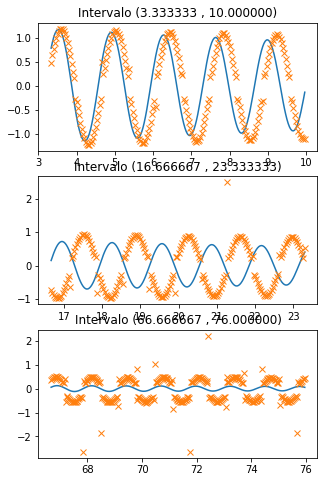

In [21]:
f, ax = plt.subplots(3,1, figsize=(5,8))
ax[0].plot(times_40cm[100:300], p1.model(p1.X, (optimal_40cm['x'],))[100:300], label='fit')
ax[0].plot(times_40cm[100:300], p1.y[100:300], 'x', label='data')
ax[0].set_title("Intervalo (%f , %f)" %(times_40cm[100], times_40cm[300]))
ax[1].plot(times_40cm[500:700], p1.model(p1.X, (optimal_40cm['x'],))[500:700], label='fit')
ax[1].plot(times_40cm[500:700], p1.y[500:700], 'x', label='data')
ax[1].set_title("Intervalo (%f , %f)" %(times_40cm[500], times_40cm[700]))
ax[2].plot(times_40cm[2000:-1], p1.model(p1.X, (optimal_40cm['x'],))[2000:-1], label='fit')
ax[2].plot(times_40cm[2000:-1], p1.y[2000:-1], 'x', label='data')
ax[2].set_title("Intervalo (%f , %f)" %(times_40cm[2000], times_40cm[-1]))
plt.show()

O modelo fornece uma boa aproximação para $\theta$ para valores não muito grandes de $t$. Porém, fica claro que, conforme $t$ aumenta, este modelo, mesmo usando o valor de $c$ que minimiza o erro, perde sua capacidade de aproximação de $\theta$. Em particular, a amplitude da solução do modelo acaba subestimando a amplitude observada na amostra.Parece que nossa consideração deste termo como $c\frac{d \theta}{d t}$ fez com que a amplitude decrescesse rápido demais. Uma alternativa é considerar um termo de atrito que decresce ao longo do tempo. Consideraremos $(1+t)^{-c} \frac{d \theta}{d t}$. Isso nos dá o seguinte modelo:

$$ \frac{d^2 \theta}{d t^2} + (1+t)^{-c} \frac{d \theta}{d t} + \frac{g}{l}\sin(\theta) = 0 $$

In [22]:
class Parametrize_ODE_2():
    def __init__(self, xdata, ydata, b_zero, lenght):
        self.X = xdata
        self.y = ydata
        self.y0 = b_zero
        self.l = lenght
    def ode(self, y, t, args):
        theta, omega = y
        dydt = [omega, -(1/(1+t)**args)*omega - (g/self.l)*np.sin(theta)]
        return dydt
    def model(self, X, *args):
            sol = integrate.odeint(self.ode, self.y0, X, *args)
            return [sol[i][0] for i in range(len(sol))] 
    def f_resid(self, c):
            return np.sum(self.y - self.model(self.X, (c,)))
    def optim(self):
        return optimize.minimize_scalar(self.f_resid)

In [23]:
p2 = Parametrize_ODE_2(times_70cm, np.array(angulos_70cm[offset_70cm:-1]), np.array([theta_0_70cm, 0]), 0.7)
optimal_70cm_2 = p2.optim()
print("Sucesso da otimizacao = ", optimal_70cm['success'])
print("Valor otimo de c = ", optimal_70cm_2['x'])

Sucesso da otimizacao =  True
Valor otimo de c =  3.4301150476178597


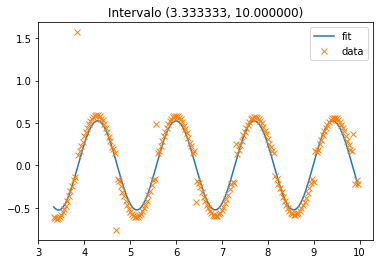

In [24]:
plt.plot(times_70cm[100:300], p2.model(po.X, (optimal_70cm_2['x'],))[100:300], label='fit')
plt.plot(times_70cm[100:300], p2.y[100:300], 'x', label='data')
plt.legend()
plt.title("Intervalo (%f, %f)" %(times_70cm[100], times_70cm[300]))
plt.show()

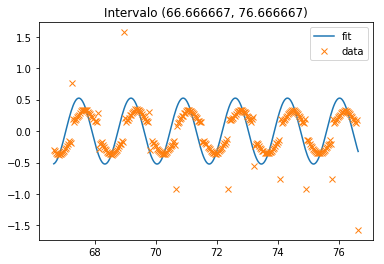

In [25]:
plt.plot(times_70cm[2000:2300], p2.model(po.X, (optimal_70cm_2['x'],))[2000:2300], label='fit')
plt.plot(times_70cm[2000:2300], p2.y[2000:2300], 'x', label='data')
plt.legend()
plt.title("Intervalo (%f, %f)" %(times_70cm[2000], times_70cm[2300]))
plt.show()

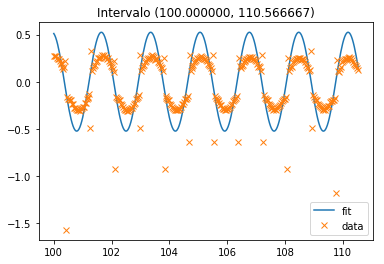

In [26]:
plt.plot(times_70cm[3000:-1], p2.model(po.X, (optimal_70cm_2['x'],))[3000:-1], label='fit')
plt.plot(times_70cm[3000:-1], p2.y[3000:-1], 'x', label='data')
plt.legend()
plt.title("Intervalo (%f, %f)" %(times_70cm[3000], times_70cm[-1]))
plt.show()

Este novo modelo conseguiu, de fato,  desacelerar o decaimento da amplitude da solução da EDO. Porém agora a solução do modelo superestima a amplitude para valores grandes de $t$. De qualquer, este modelo também se demonstra adequado para aproximação de $\theta$ para valores não muito grandes de $t$, como pode ser visto nos gráficos. 

###### Conclusão: 

Consideramos três modelos. O primeiro não considera a ação do atrito sob o sistema. Como consequência ele não inclui o decaimento da amplitude ao longo do tempo, imediatamente tornando este modelo inadequado para situações práticas(pelo menos na Terra!). O segundo modelo adiciona um termo de atrito que é proporcional à $\frac{d \theta}{dt}$. Este modelo fornece boas aproximações para o ângulo $\theta$ para instantes iniciais. Ao longo do tempo, sua aproximação piora e ele passa a subestimar a amplitude do pêndulo. Já no terceiro modelo o termo $\frac{d \theta}{dt}$ é multiplicado por $(1+t)^{-c}$, a fim de diminuir o impacto deste termo conforme $t$ cresce, em uma tentativa de não subestimar a amplitude, assim como o segundo modelo fazia. Assim como os demais, este modelo aproxima bem o ângulo nos instantes iniciais, porém, desta vez, conforme $t$ aumenta, este modelo tende a superestimar a amplitude. 

Sob o custo de complexidade, é possível considerar modelos mais complexos, com mais termos envolvidos, e que modelem melhor o decaimento da amplitude, porém este custo de complexidade pode ser muito alto, tanto para simulação numérica quanto ao ajuste de parâmetros.

Concluímos que tanto o segundo quanto o terceiro modelo são simples, porém,  pertinentes para simulações do ângulos do pêndulo em um contexto que em há atrito(com ar ou com outro fluído) no sistema e dentro de um intervalo de tempo não muito extenso, sendo uma alternativa melhor do que o primeiro modelo.

### Dependência do período na amplitude:

Estimaremos a partir dos dados o período tanto para o pêndulo de $70$ cm quanto para o de $40$ cm. Cada um deles tem um ângulo inicial. Vamos comparar esta estimativa a partir da amostra com as outras formas que vimos na *Aula $8$* de estimar o período dado uma certa amplitude, em particular, as duas seguintes: 1- $T_p$; 2- o polinômio analítico proposto; 3- a expressão que envolve AGM. 

In [27]:
def periodos(times, data):
    indexes = argrelmax(data, order=10)[0]
    periodos = []
    for i in range(1, len(indexes)):
        periodos.append(times[indexes[i]] - times[indexes[i-1]] )
    return periodos

In [28]:
periodo_70cm = np.mean(np.array(periodos(times_70cm, angulos_70cm[offset_70cm:2700])))
print("Periodo amostral do pendulo de 70cm = ", periodo_70cm)
print("Angulo inicial = ", angulos_70cm[offset_70cm])

Periodo amostral do pendulo de 70cm =  1.8696969696969696
Angulo inicial =  -0.6284637981686765


In [42]:
periodo_40cm = np.mean(np.array(periodos(times_40cm, angulos_40cm[offset_40cm:2000])))
print("Periodo amostral do pendulo de 40cm = ", periodo_40cm)
print("Angulo inicial = ", angulos_40cm[offset_40cm])

Periodo amostral do pendulo de 40cm =  1.374814814814815
Angulo inicial =  -1.3507256653812894


Podemos também usar os modelos de EDO que ajustamos para estimação do período. 

In [90]:
periodo_70cm_modelo1 = np.mean(np.array(periodos(times_70cm, np.array(po.model(po.X, (optimal_70cm['x'],))))))
print("Periodo simulado 70cm modelo 1 = ", periodo_70cm_modelo1)
print("Diferenca para o periodo amostral", periodo_70cm_modelo1 -  periodo_70cm)

Periodo simulado 70cm modelo 1 =  1.6856410256410257
Diferenca para o periodo amostral -0.18405594405594394


In [91]:
periodo_70cm_modelo2 = np.mean(np.array(periodos(times_70cm, np.array(p2.model(po.X, (optimal_70cm_2['x'],))))))
print("Periodo simulado 70cm modelo 2 = ", periodo_70cm_modelo2)
print("Diferenca para o periodo amostral", periodo_70cm_modelo2 -  periodo_70cm)

Periodo simulado 70cm modelo 2 =  1.7083333333333335
Diferenca para o periodo amostral -0.16136363636363615


In [92]:
periodo_40cm_modelo = np.mean(np.array(periodos(times_40cm, np.array(p1.model(p1.X, (optimal_40cm['x'],))))))
print("Periodo simulado 40cm modelo 1= ", periodo_40cm_modelo)
print("Diferenca para o periodo amostral", periodo_40cm_modelo -  periodo_40cm)

Periodo simulado 40cm modelo 1=  1.2942528735632184
Diferenca para o periodo amostral -0.08056194125159655


A primeira estimativa que vamos analisar é dada por $T_p(l) = 2\pi \sqrt{\frac{l}{g}}$:

In [95]:
print("T_p(0.7) = ", 2*np.pi*np.sqrt(0.7/g))
print("Diferenca para o periodo amostral", 2*np.pi*np.sqrt(0.7/g) -  periodo_70cm)

T_p(0.7) =  1.6786824519757624
Diferenca para o periodo amostral -0.19101451772120726


In [96]:
print("T_p(0.4) = ", 2*np.pi*np.sqrt(0.4/g))
print("Diferenca para o periodo amostral", 2*np.pi*np.sqrt(0.4/g) -  periodo_40cm)

T_p(0.4) =  1.2689646566217128
Diferenca para o periodo amostral -0.10585015819310217


Na aula $8$ foi proposto o seguinte polinômio(analítico) para o período do pêndulo dado o ângulo inicial $t$.

In [33]:
# coeficientes da expansao analitica T(t) em potencias pares de t
cis =[0 for i in range(200)]
# desde wiki pendulo (math), https://oeis.org/A223068/list
denoms = [1,16,3072,737280,1321205760,951268147200, 2009078326886400,265928913086054400, 44931349155019751424000,
 109991942731488351485952000, 668751011807449177034588160000, 2471703739640332158319837839360000]
#https://oeis.org/A223067/list
numers = [1,1,11,173,22931,1319183,233526463,2673857519,39959591850371,8797116290975003,4872532317019728133,1657631603843299234219,
 247098748783812523360613, 77729277912104164732573547,1503342018433974345747514544039]
for i in range(len(denoms)):
    cis[2*i]= numers[i]/denoms[i]

In [37]:
class Polinomio():
    def __init__(self, coefficients):
        self.coef = coefficients
    def evaluate(self, t):
        value = 0
        for i in range(len(self.coef)):
            value += self.coef[i]*(t**i)
        return value 

In [38]:
poli = Polinomio(cis)

Este polinômio nos dá os seguintes valores para o período dos pêndulos de $70$cm e $40$cm:

In [85]:
print("Periodo 70cm = ", 2*np.pi*np.sqrt(0.7/g)*poli.evaluate(theta_0_70cm))
print("Diferenca para o periodo amostral", 2*np.pi*np.sqrt(0.7/g)*poli.evaluate(theta_0_70cm) -  periodo_70cm)

Periodo 70cm =  1.7210841317650651
Diferenca para o periodo amostral -0.1486128379319045


In [86]:
print("Periodo 40cm = ", 2*np.pi*np.sqrt(0.4/g)*poli.evaluate(theta_0_40cm))
print("Diferenca para o periodo amostral", 2*np.pi*np.sqrt(0.4/g)*poli.evaluate(theta_0_40cm) -  periodo_40cm)

Periodo 40cm =  1.4308822419450407
Diferenca para o periodo amostral 0.05606742713022572


Também consideramos a fórmula:

$$ T(\theta_0) = 2\pi \sqrt{ \frac{l}{g} } AGM\Big( 1, \cos\big( \frac{\theta_0}{2} \big) \Big) $$

In [80]:
def medias(a,b): #cuidar de colocar numeros positivos a,b
    y1 = (a+b)/2
    y2 = np.sqrt(a*b)
    return y1,y2

def agm(a,b): #cuidar de colocar numeros positivos a,b
    y1,y2 = a,b
    itera = 0
    while np.abs(y1-y2) > 10**(-10):
        y1,y2 = medias(y1,y2)
        itera += 1
    return y1, itera

def periodo_agm(t, l):
    return 2*np.pi*np.sqrt(l/g)/agm(1.0, np.cos(t/2))[0]

Isto nos dá os valores:

In [88]:
print("Periodo 70cm agm = ", periodo_agm(theta_0_70cm, 0.7))
print("Diferenca para o periodo amostral", periodo_agm(theta_0_70cm, 0.7) -  periodo_70cm)

Periodo 70cm agm =  1.7210841317650654
Diferenca para o periodo amostral -0.14861283793190427


In [89]:
print("Periodo 40cm agm = ", periodo_agm(theta_0_40cm, 0.4))
print("Diferenca para o periodo amostral", periodo_agm(theta_0_40cm, 0.4)  -  periodo_40cm)

Periodo 40cm agm =  1.430882242069822
Diferenca para o periodo amostral 0.05606742725500702


###### Comentário:

Erros de medição são intrínsecos a qualquer experimento. No caso do nosso experimento, há algumas fontes de erro suspeitas: uma falta de alinhamento(paralelismo) entre o plano da câmera e o plano no qual o pêndulo oscila; a precisa identificação da localização da bola pelo algoritmo de visão computacional. Também fizemos a suposição de que o centro da bola se encontra no centro da caixa, o que propaga ainda mais este último erro. Além da conversão para ângulos, o que propicia erro númerico por parte do computador.


##### Conclusão:

Tendo este comentário em mente, podemos ver que os dois métodos(polinômio analítico e AGM) que propomos estudar forneceram estimativas boas para o período em função do ângulo inicial. As simulações numéricas dos modelos de EDO também deram boas aproximações. Em todos os casos a ordem do erro ficou em torno de $0.1$, sendo o erro máximo de $\approx 0.18$. Também comparamos os resultados de $T_p(l) = 2\pi \sqrt{\frac{l}{g}}$ com os dados e confirmamos a conclusão da Aula $8$ de que esta estimativa subestima o período para ângulos $> 23^o$, que é o caso dos dois experimentos.